# Introduction

While meeting with the team on March 1st, a problem was described to me where the team received a dataset that described a profile of a producing oil well in terms of production amount vs. time.  The team's objective was to produce a model predicting such profiles.  The team described how there would be time periods with zero production, and time periods with missing data, but those could easily be identified and removed from the dataset.  A more difficult issue was the presence of non-zero, but artificially lowered periods of production, after which production would return to previous levels (or levels consistent with a curve).  These "gaps" were difficult to algorithmically identify, and would cause problems for the predictive model when included in the training dataset.

After the meeting, I thought about the problem of identifying these "gaps", and had the thought that the problem could be treated as a segmentation problem, with a model that predicts whether each data point could be included in the dataset.

To test my model I have created this notebook to create simulated data, train a model, and analyze the performance of the model.

# Setup

We'll need the [fast.ai library]()

In [1]:
# !curl -s https://course.fast.ai/setup/colab | bash

In [2]:
# !pip uninstall fastai # In case there are issues with the version installed by the above line.

In [3]:
# !pip install fastai

In [4]:
%reload_ext autoreload
%autoreload 2

In [5]:
from fastai import *
from fastai.data_block import *
from fastai.torch_core import *
from fastai.layers import *
from fastai.basic_train import *
from fastai.train import *
from fastai.callbacks.hooks import *

import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
import numpy as np
import functools as ft

We'll also be looking at the simulated profiles.

In [6]:
def lin_plot(vs,mask,*args):
    assert len(args)%2 == 0, "Expected even number of axis views."
    for arg in args:
        assert len(arg) == 2, "Arguments >0 must be value range pairs."
        for x in arg:
            assert isinstance(x,float) or isinstance(x,int), \
                "Expected numerical values in value range pairs."
    
    xranges,yranges = args[0::2],args[1::2]
    fig = plt.figure(figsize=(4*len(xranges)+len(xranges), 4))
    
    mask = [1 for v in vs] if mask is None else mask
    
    if isinstance(vs, torch.Tensor):
      vs = to_np(vs)
    
    n = len(xranges)
    
    for i,(xrange,yrange) in enumerate(zip(xranges,yranges)):
        ax = fig.add_subplot(1,n,i+1)
        
        vs_split = []
        acc = []
        lastm = 1
        for m,v in zip(mask,vs):
          if m == lastm:
            acc.append(v)
          else:
            if acc: vs_split.append((lastm,acc))
            acc = [v]
          lastm = m
        vs_split.append((m,torch.Tensor(acc)))
        
        for m,v_list in vs_split:
          path = patches.Path(v_list)
          color = 'blue' if bool(m == 1) else 'red'
          alpha = 1.0

          pathpatch = patches.PathPatch(path, facecolor='none', edgecolor=patches.colors.to_rgba(color,alpha))
          patch = ax.add_patch(pathpatch)
        ax.set_xlim(xrange[0],xrange[1])
        ax.set_ylim(yrange[0],yrange[1])
    plt.show()

# Generating fake production profiles

We want to train the model on simulated data to find artificially low levels of production.  The idea will be that the network will flag those data points for removal.  The sample graph that was drawn for me looked roughly like a noisy exponential decay curve with gaps of artificially lower production, so this is the type of simulated data we'll create.

First we'll choose a data set size.  Since the data is simulated, it can be as large as we want.

In [7]:
data_sz = 50000

We don't want to store all the data points from every profile, so we want a way to take a few parameters and generate a profile on-the-fly.  We'll start by generating a profile with no gaps...

In [8]:
def f(a, b, k, x):
  return a*torch.exp(-x*k)+b

In [9]:
def getprofile(length,interval,a,b,k):
  xs = torch.Tensor([interval[1]*i/length+interval[0] for i in range(length)])
  return xs,f(a,b,k,xs)

Let's have a look at a sample profile.

In [10]:
interval = (0.0,10.0)
length = 10000

xs,ys = getprofile(length,interval,1.0,0.0,0.2)
vs = torch.stack([xs,ys]).transpose(0,1)

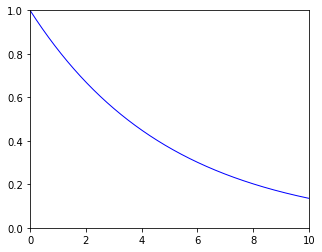

In [11]:
lin_plot(vs, None, [0,10], [0,1])

We also want the profile to be noisy, so here's how we'll add some noise to it.

In [12]:
std = 0.01
noise = std * torch.randn(length)

In [13]:
x = ys.add_(noise).clamp(0.,5.)

In [14]:
vs = torch.stack([torch.Tensor(xs),x]).transpose(0,1); vs.shape

torch.Size([10000, 2])

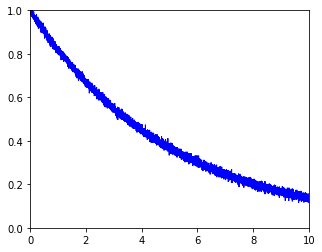

In [15]:
lin_plot(vs, None, [0,10], [0,1])

Now we need to add gaps in the data.   We'll start by generating integers that represent the number of gaps in each profile.

In [16]:
num_gaps = np.stack([np.random.normal(1.,1.,data_sz).astype(int),np.zeros((data_sz,),dtype=int)]).max(0); num_gaps[0:10]

array([1, 0, 1, 1, 0, 1, 1, 0, 0, 0])

Each gap is generated randomly as below.  `interval` is the total (fake) time interval on which the data is defined, `avg_size` is the nominal average size desired for gaps, but not quite because we will arbitrarily truncate the randomly generated gaps to exist only on the appropriate time interval (which shortens the actual average) and sometimes the gaps will overlap and be effectively a single gap (which increases the actual average).

The function returns the start and end of the gap (in terms of the time axis), and the factor by which the data will be multiplied (between 0 and 1).

In [17]:
def random_gap(interval, avg_size):
  low,high = interval
  middle = np.random.uniform(low,high)
  size = np.abs(np.random.normal(0.,avg_size))
  start = max(middle-size/2,low)
  end   = min(middle+size/2,high)
  drop_factor = np.random.uniform(0.,1.)
  return start,end,drop_factor

In [18]:
random_gap(interval,avg_size=1) # Start x-value, end x-value, factor of decrease.

(1.8893965318695292, 2.6594736326006974, 0.4446138303729432)

The above will be passed to our new `ItemList` class.  Now we need a way to take a curve and add the gaps...

In [19]:
def getmults(xs, gaplist):
  mults = torch.ones_like(xs)
  for gap in gaplist:
    start,end,mult = gap
    mask = (torch.lt((start*torch.ones_like(xs)),xs)*torch.lt(xs,(end*torch.ones_like(xs)))).to(dtype=torch.float32)
    mults =  mults * ((mask*mult) + (1.-mask))
  return mults  

...and a way to generate labels, i.e. which data points on the profile we want the model to identify as gaps.

In [20]:
def getlabels(xs, gaplist):
  labels = torch.zeros_like(xs)
  for gap in gaplist:
    start,end,mult = gap
    mask = (torch.lt((start*torch.ones_like(xs)),xs)*torch.lt(xs,(end*torch.ones_like(xs)))).to(dtype=torch.float32)
    labels = labels + mask
  return 1.-labels.clamp(0.,1.)

Here's a sample of what we'll multiply a profile by, elementwise.  First create a list of gaps then generate the multipliers.

In [21]:
gaplist = [(7.895473695650945, 8.5611717232079, 0.7412393215396834),
 (9.42338378189132, 10.0, 0.49183629537436746),
 (3.267080298267579, 4.566375305422216, 0.9222552666207067)]

In [22]:
%time mults = getmults(xs,gaplist)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.4 ms


Now let's incorporate the gaps in our sample profile.

In [23]:
x = ys*mults

In [24]:
vs = to_np(torch.stack([torch.Tensor(xs),x]).transpose(0,1)); vs.shape

(10000, 2)

Here's the result, with a demo of labelling.

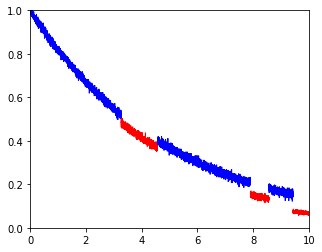

In [25]:
lin_plot(vs, getlabels(xs,gaplist), [0,10], [0,1])

# Generate dataset

This is what we'll store in the dataset to generate the gaps.

In [26]:
avg_size = 1.
gaps = [[random_gap(interval,avg_size) for i in range(n)] for n in num_gaps]

In [27]:
a_list = np.random.uniform(.8,5.,data_sz)
b_list = np.random.uniform(0.,.3,data_sz)
k_list = np.random.uniform(0.1,0.4,data_sz)
profile_params = np.array( list(zip(list(zip(list(a_list),list(b_list),list(k_list))),gaps)) )

In [28]:
items = array(gaps, dtype=object)

# An ItemList to handle the data in fast.ai.

The `ProfileItemList` (subclassing a fast.ai wrapper for PyTorch datasets, sort of) will store the parameters for all profiles in (regular) memory and build and serve full profiles to the dataloader on the fly as PyTorch `Tensor`s, which will end up in GPU memory one batch at a time.  The noise is generated randomly, so the profile won't be exactly the same each time it's served, but this is fine (even desirable).

In [29]:
class ProfileLabelItemList(ItemList):

    def __init__(self, items, noise_mag=0.01, length=10000, interval=(0.,10.), **kwargs):
        super().__init__(items, **kwargs)
        self.noise_mag,self.length,self.interval = noise_mag,length,interval
        
    def get(self, i): 
        noise = self.noise_mag * torch.randn(self.length)
        xs,ys = getprofile(self.length,self.interval,*self.items[i][0])
        label = getlabels(xs,self.items[i][1])
        return label

In [30]:
class ProfileItemList(ItemList):
    _label_cls = ProfileLabelItemList

    def __init__(self, items, noise_mag=0.01, length=10000, interval=(0.,10.), **kwargs):
        super().__init__(items, **kwargs)
        self.noise_mag,self.length,self.interval = noise_mag,length,interval
        
    def get(self, i): 
        noise = self.noise_mag * torch.randn(self.length)
        xs,ys = getprofile(self.length,self.interval,*self.items[i][0])
        mults = getmults(xs,self.items[i][1])
        return (ys.add_(noise)*mults).unsqueeze(0)

In [31]:
il = ProfileItemList(profile_params, 0.01, 10000, (0.,10.))

In [32]:
labels = ProfileLabelItemList(profile_params, 0.01, 10000, (0.,10.))

In [33]:
i = 1

il.items[i]

array([(4.326130399321864, 0.2831901993459731, 0.3636193862731011), list([])], dtype=object)

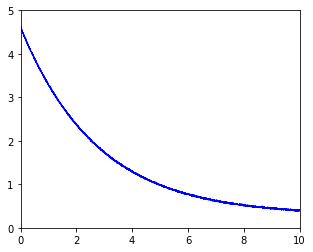

In [34]:
lin_plot(list(zip(xs,il[i].squeeze())),labels[i],[0,10],[0,5])

In [35]:
il,labels = il.no_split(),labels.no_split()

In [36]:
train,valid = LabelList(il.train,labels.train),LabelList(il.valid,labels.valid)

In [37]:
lls = LabelLists('.',train,valid)

In [38]:
db = lls.databunch()

# Model

## Framework

We will use a variation on the [U-net](https://arxiv.org/abs/1505.04597) model which was developed for image segmentation.  We are not processing images here, but we are trying to predict a mask on a 1-d set of data points, which is similar.  Therefore, we will use a 1-d convolutional model that uses an encoder/decoder structure with nested skip-connections.

Much of the following was modified from the fast.ai library.

TODO

* Make upsampling dynamic by letting the interpolate look at the captured data.

In [39]:
def _bn(ni, init_zero=False):
    "Batchnorm layer with 0 initialization"
    m = nn.BatchNorm1d(ni)
    m.weight.data.fill_(0 if init_zero else 1)
    m.bias.data.zero_()
    return m
  
def bn_relu_conv(ni, nf, ks, stride, init_zero=False):
    bn_initzero = _bn(ni, init_zero=init_zero)
    return nn.Sequential(bn_initzero, nn.ReLU(inplace=True), conv1d(ni, nf, ks, stride))

class BasicBlock(nn.Module):
    "Block from a wide ResNet."
    def __init__(self, ni, nf, stride, drop_p=0.0):
        super().__init__()
        self.bn = nn.BatchNorm1d(ni)
        self.conv1 = conv1d(ni, nf, bb_kernel_sz, stride)
        self.conv2 = bn_relu_conv(nf, nf, bb_kernel_sz, 1)
        self.drop = nn.Dropout(drop_p, inplace=True) if drop_p else None
        self.shortcut = conv1d(ni, nf, 1, stride) if (ni != nf or stride != 1) else noop

    def forward(self, x):
        x2 = F.relu(self.bn(x), inplace=True)
        r = self.shortcut(x2)
        x = self.conv1(x2)
        if self.drop: x = self.drop(x)
        x = self.conv2(x) * 0.2
        return x.add_(r)

In [40]:
def conv1d(ni:int, no:int, ks:int=1, stride:int=1, padding=None, bias:bool=False):
    "Create and initialize `nn.Conv1d` layer."
    if padding is None: padding = ks//2
    conv = nn.Conv1d(ni, no, ks, stride=stride, padding=padding, bias=bias)
    nn.init.kaiming_normal_(conv.weight)
    if bias: conv.bias.data.zero_()
    return spectral_norm(conv)

In [41]:
class UpSample(nn.Module):
    def __init__(self,feat_in,feat_out):
        super().__init__()
        self.conv = nn.Conv1d(feat_in,feat_out,kernel_size=bb_kernel_sz,stride=1,padding=bb_kernel_sz//2)
    
    def forward(self,x):
        return self.conv(
              nn.functional.interpolate(
                x,size=self.hook.stored.shape[-1],scale_factor=None,mode='linear',align_corners=True))

In [42]:
def basic_up(ni:int, no:int):
  return nn.Sequential(UpSample(ni, no),nn.ReLU()) 

In [43]:
class Dec_wrapper(nn.Module):
  def __init__(self,module,hook,add_mode):
    super().__init__()
    self.module,self.hook,self.add_mode = module,hook,add_mode
  def forward(self,x):
    return self.module(x)+self.hook.stored if self.add_mode else torch.cat([self.module(x),self.hook.stored],dim=1)

In [44]:
class Decoder(SequentialEx):
    def __init__(self, encoder:nn.Module, decoderlist, add_mode=True):
        self.sfs = hook_outputs(encoder[:-1])

        layers = []
        for dec,hook in zip(decoderlist[:-1],reversed(self.sfs)):
          dec[0][0].hook = hook
          layers.append(Dec_wrapper(dec,hook,add_mode))
        layers.append(decoderlist[-1])
        
        super().__init__(*layers)


In [45]:
class Noop_module(nn.Module):
  def forward(self,x):
    return noop(x)

In [46]:
def sequentialize(l):
  return SequentialEx(*list(l)).cuda()

## Construction

We now have the pieces needed to build the encoder and decoder.

In [91]:
bb_kernel_sz = 3 # 3
min_feat = 16 # 64
max_feat = 64 # 256
n_lay = 7 # 6
scaling = 2 # 2
add_mode = True # True
feats = [(min(max_feat, min_feat*(2 ** i)), min(max_feat, min_feat*(2 ** (i+1)))) for i in range(n_lay)]

feats

[(16, 32), (32, 64), (64, 64), (64, 64), (64, 64), (64, 64), (64, 64)]

In [92]:
enc_layers = [
              [BasicBlock(in_f,out_f,scaling),BasicBlock(out_f,out_f,1)]
              for (in_f,out_f) in feats
             ]

initial = Noop_module()
hook = hook_output(initial)

enc_layers = [[initial,conv1d(1,min_feat,9,3,None,True),nn.ReLU(),BasicBlock(min_feat,min_feat,1)]] + enc_layers

enc = list(map(sequentialize, enc_layers))

# enc = [Input_wrapper(conv1d(1,min_feat,9,3,None,True),nn.ReLU(),BasicBlock(min_feat,min_feat,1))] + enc

In [93]:
encoder = SequentialEx(*enc)

For the decoder we first construct the layers...

In [94]:
def iszeroth(i,n):
    return n*2 if (i != 0 and not add_mode) else n

dec_layers = [
              [basic_up(iszeroth(i,in_f),out_f),BasicBlock(out_f,out_f,1)] 
              for i,(out_f,in_f) in enumerate(reversed(feats)) 
             ]

last_f = feats[0][0]

last_up = basic_up(last_f*(2 ** (1-int(add_mode))),last_f)
list(last_up.children())[0].hook = hook

dec_layers += [[last_up,BasicBlock(last_f,last_f,1),conv1d(last_f,1,9,1,None,True),nn.Sigmoid()]]

dec = list(map(sequentialize, dec_layers))

...then we wrap them with hooks from the encoder layers so they can receive additional input across many layers.

In [95]:
decoder = Decoder(encoder,dec,add_mode)

In [96]:
model = nn.Sequential(encoder,decoder)

In [97]:
dummy_eval(model,(5000,)).shape

torch.Size([1, 1, 5000])

# Loss Function

For a loss function we use a variation on the DICE loss function (described [here](https://www.jeremyjordan.me/semantic-segmentation/#loss)).

In [98]:
def dice(preds,targs):
  return .5-((1.-preds.squeeze())*(1.-targs)).mean()/((1.-preds.squeeze()).mean()+(1.-targs).mean())

# Training

In [99]:
learn = Learner(db,model.cuda(),loss_func=dice)

In [100]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.75E-02


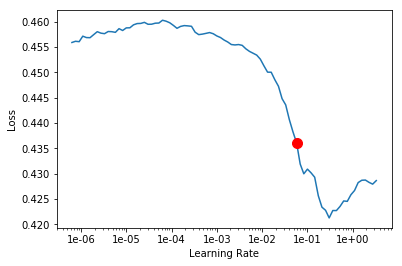

In [101]:
learn.recorder.plot()

In [78]:
learn.data.train_ds.length = 10000
learn.data.train_ds.x.length = 10000
learn.data.train_ds.y.length = 10000
print(learn.data.train_ds[0][0].shape,learn.data.train_ds[0][1].shape)
# x,y = learn.data.one_batch()

torch.Size([1, 10000]) torch.Size([10000])


In [73]:
y.shape

torch.Size([64, 1000])

In [102]:
learn.fit_one_cycle(4,max_lr=5e-2) # 2500->.019, 10000->.011

epoch,train_loss,valid_loss
1,0.139137,
2,0.054236,
3,0.022336,
4,0.012273,


In [103]:
learn.fit_one_cycle(4,max_lr=1e-3)

epoch,train_loss,valid_loss
1,0.012039,
2,0.010262,
3,0.010463,
4,0.010964,


In [0]:
# learn.fit_one_cycle(4,max_lr=1e-2) #kernel size 9

epoch,train_loss,valid_loss
1,0.146296,
2,0.032849,
3,0.013838,
4,0.008498,


In [0]:
learn.fit_one_cycle(4,max_lr=1e-2) # kernel size 3

epoch,train_loss,valid_loss
1,0.215850,
2,0.025959,
3,0.013210,
4,0.008636,


In [0]:
learn.fit_one_cycle(6,max_lr=1e-2,pct_start=0.4) # kernel size 5, scale factor 2, layers 7, add

epoch,train_loss,valid_loss
1,0.206148,
2,0.079131,
3,0.072281,
4,0.036109,
5,0.026434,
6,0.019754,


ValueError: x and y must have same first dimension, but have shapes (6,) and (0,)

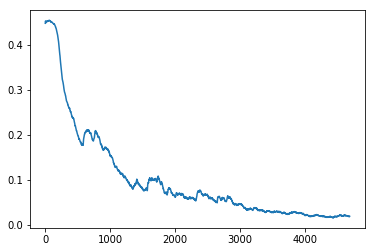

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.fit_one_cycle(4,max_lr=1e-1) # kernel size 3, scale factor 2, layers 5

epoch,train_loss,valid_loss
1,0.203670,
2,0.118773,
3,0.028862,
4,0.023105,


In [0]:
learn.fit_one_cycle(4,max_lr=1e-2) # kernel size 3, scale factor 2, concat

epoch,train_loss,valid_loss
1,0.105276,
2,0.049572,
3,0.028856,
4,0.018294,


In [0]:
learn.fit_one_cycle(4,max_lr=1e-4) # kernel size 3, scale factor 2, concat

epoch,train_loss,valid_loss
1,0.017256,
2,0.018445,
3,0.017197,
4,0.018827,


In [0]:
learn.fit_one_cycle(4,max_lr=4e-2)

epoch,train_loss,valid_loss
1,0.179769,
2,0.063107,
3,0.027834,
4,0.013499,


In [0]:
learn.fit_one_cycle(1,max_lr=1e-4)

epoch,train_loss,valid_loss
1,0.037221,


# Analysis

In [104]:
x,y = db.one_batch()

The model is quite accurate for many profiles:

In [130]:
torch.gt(learn.model(x[i].unsqueeze(0).cuda()).squeeze()[3990:4010],1e-15)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0', dtype=torch.uint8)

In [131]:
learn.model(x[i].unsqueeze(0).cuda()).squeeze()[3990:4010].gt(1e-15)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0', dtype=torch.uint8)

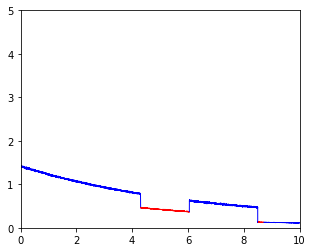

In [153]:
i = 8
lin_plot(list(zip(xs,x[i].squeeze())),learn.model(x[i].unsqueeze(0).cuda()).gt(1e-1).squeeze(),[0,10],[0,5]) # Predicted labels

In [119]:
learn.model(x[i].unsqueeze(0).cuda()).squeeze()[2990:3010]

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000], device='cuda:0', grad_fn=<SliceBackward>)

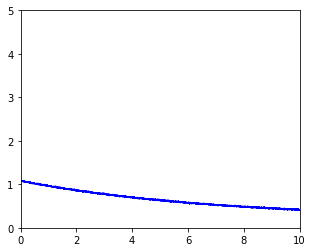

In [110]:
lin_plot(list(zip(xs,x[i].squeeze())),y[i].squeeze(),[0,10],[0,5]) # Actual labels

However, it has some issues with falsely labeling real data as fake, particularly when no gaps are present in a profile:

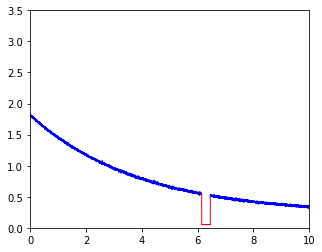

In [120]:
i = 1
lin_plot(list(zip(xs,x[i].squeeze())),learn.model(x[i].unsqueeze(0).cuda()).round().squeeze(),[0,10],[0,3.5]) # Predicted labels

In [125]:
learn.model(x[i].unsqueeze(0).cuda()).squeeze()[6200:6220]

tensor([4.1689e-30, 3.4685e-30, 2.9123e-30, 2.4666e-30, 2.1068e-30, 1.8139e-30,
        1.5744e-30, 1.3773e-30, 1.2145e-30, 1.0794e-30, 9.6682e-31, 8.7253e-31,
        7.9311e-31, 7.2582e-31, 6.6852e-31, 6.1935e-31, 5.7692e-31, 5.4006e-31,
        5.0798e-31, 4.8002e-31], device='cuda:0', grad_fn=<SliceBackward>)

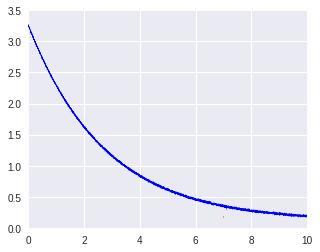

In [0]:
lin_plot(list(zip(xs,x[i].squeeze())),y[i].squeeze(),[0,10],[0,3.5]) # Actual labels

# Conclusion

Despite some issues with false positives, the performance of the model is quite good on the simulated data.  More information from the team would be needed to see whether the model would work as well on the real data.  Training on simulated data is generally a vulnerable process, and it would be preferrable to train on actual profiles, but it's unknown to me how much real data is available.  The model as it was demonstrated in this notebook had essentially unlimited data with which to train.  If real data is scarce, perhaps the real data could be analyzed to improve the quality of the simulated data to make it better for training.

Assuming this model is suitable for the task, it can probably be simplified in a way that maintains or improves accuracy while decreasing training and inference time.  Other areas of potential improvement are:

* Normalize input data
* Increase receptive field sizes
* Experiment with other skip connection styles, e.g. concatenation rather than addition
* Integrate this model with the predictive model for single-pass training and prediction

Hopefully this model can be helpful to the OAG data science team.